To copy this template: File -> Save a Copy in Drive

***DISCLAIMER**: In case of any discrepancy in the assignment instruction, please refer to the `PDF` document.*

# Problem 5 - Learning Rate, Batch Size, FashionMNIST

## 5.1

4422102/4422102 [==============================] - 0s 0us/step


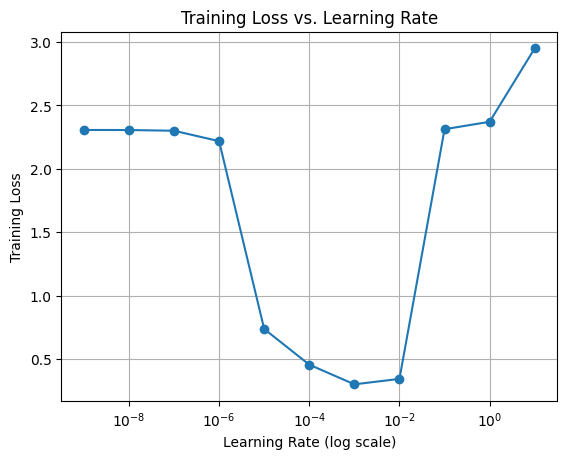

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt

# Load FashionMNIST dataset
(x_train, y_train), (_, _) = fashion_mnist.load_data()

# Preprocess the data
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255
y_train = tf.keras.utils.to_categorical(y_train, 10)

# Define the LeNet-5 model
model = Sequential([
    Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set batch size and candidate learning rates
batch_size = 64
candidate_learning_rates = [10**i for i in range(-9, 2)]
epochs = 5

# Initialize lists to store learning rates and corresponding losses
learning_rates = []
losses = []

# Train the model for each learning rate
for lr in candidate_learning_rates:
    model.optimizer.lr.assign(lr)  # Set the learning rate
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
    learning_rates.append(lr)
    losses.append(history.history['loss'][-1])

# Plot the training loss as a function of the learning rate
plt.semilogx(learning_rates, losses, marker='o')
plt.title('Training Loss vs. Learning Rate')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Training Loss')
plt.grid(True)
plt.show()

# Identify lrmin and lrmax based on the plot
lrmin = learning_rates[losses.index(min(losses))]
lrmax = learning_rates[losses.index(max(losses))]

print(f"lrmin: {lrmin}, lrmax: {lrmax}")


In [ ]:
# Identify lrmin and lrmax based on the plot
lrmin = learning_rates[losses.index(min(losses))]
lrmax = learning_rates[losses.index(max(losses))]

print(f"lrmin: {lrmin}, lrmax: {lrmax}")

lrmin: 0.001, lrmax: 10


**Answer:**
On the left of the graph with a small learning rate, there is a very high training loss. As the learning rate increases the training rate stays similiar until around 10-6 when it begins to decrease steeply. This means that a learning rate that is between 10-8 and 10-6 is not ideal.
The model reaches its minimum at 10-3. After this it begins to increase sharply until 10-3. As the model goes towards a learning rate of 10-0 the training loss increasing indicating that the learning rate is too big and is causing potential divergence

lr minimum is 10-4 and the minimum is about 10-2. Therefore learning rate should be between these two values.


## 5.2

4422102/4422102 [==============================] - 0s 0us/step
Epoch 1/5
938/938 [==============================] - 29s 29ms/step - loss: 0.5865 - accuracy: 0.7871 - val_loss: 0.4483 - val_accuracy: 0.8363 - lr: 0.0010
Epoch 2/5
938/938 [==============================] - 36s 39ms/step - loss: 0.3865 - accuracy: 0.8595 - val_loss: 0.3823 - val_accuracy: 0.8575 - lr: 0.0010
Epoch 3/5
938/938 [==============================] - 28s 30ms/step - loss: 0.3398 - accuracy: 0.8778 - val_loss: 0.3570 - val_accuracy: 0.8705 - lr: 0.0010
Epoch 4/5
938/938 [==============================] - 27s 29ms/step - loss: 0.3129 - accuracy: 0.8850 - val_loss: 0.3382 - val_accuracy: 0.8785 - lr: 0.0010
Epoch 5/5
938/938 [==============================] - 28s 30ms/step - loss: 0.2921 - accuracy: 0.8925 - val_loss: 0.3355 - val_accuracy: 0.8759 - lr: 0.0010


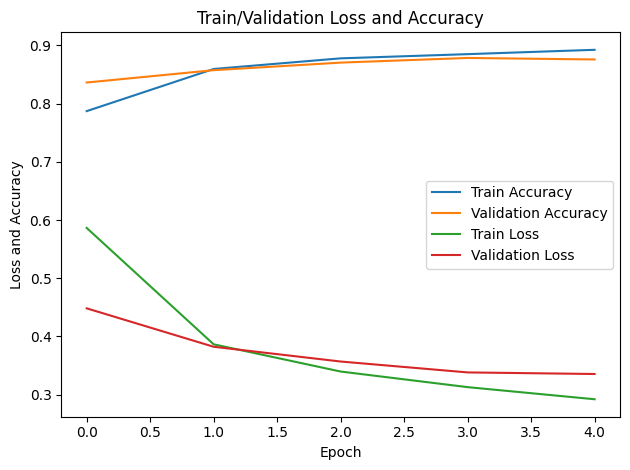

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt

# Load FashionMNIST dataset
(x_train, y_train), (x_val, y_val) = fashion_mnist.load_data()

# Preprocess the data
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255
y_train = tf.keras.utils.to_categorical(y_train, 10)

x_val = x_val.reshape(-1, 28, 28, 1).astype('float32') / 255
y_val = tf.keras.utils.to_categorical(y_val, 10)

# Define the LeNet-5 model
model = Sequential([
    Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(10, activation='softmax')
])

# Set batch size, lrmin, and lrmax
batch_size = 64
lrmin = 1e-3
lrmax = 1e-2

# Define the cyclical learning rate schedule
def cyclical_learning_rate(epoch, lr):
    step_size = 4 * (len(x_train) // batch_size)  # 4 cycles per epoch
    cycle = 1 + epoch / step_size
    x = abs(1 - (epoch / (step_size // 2))) if epoch < step_size // 2 else 0
    new_lr = lrmin + (lrmax - lrmin) * max(0, 1 - x)
    return new_lr

# Compile the model with cyclical learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrmin),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for cyclical learning rate
lr_callback = tf.keras.callbacks.LearningRateScheduler(cyclical_learning_rate)

# Train the model
epochs = 5
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(x_val, y_val), verbose=1, callbacks=[lr_callback])

# Plot combined train/validation loss and accuracy curve over the number of epochs
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss and Accuracy')
plt.legend()
plt.title('Train/Validation Loss and Accuracy')

plt.tight_layout()
plt.show()


**Answer:**
The training loss staers at 0.6 and decreases consistently as epochs increases. There is a bit of an elbow at epoch 1. At 4 epochs it is about 0.3

The validation loss begins between 0.4 and 0.5. It has a steady decrease as epochs increase. It ends close to training loss but a but above at around 0.3.

The train acuracy begings around 0.8 and increases gradually as epochs increase with a bit of an elbow around epoch 1. At 4 epoch it is about 0.9

The validation accuracy begins a bit above 0.8. Just above train accuracy and has a similar trend. It ends just below training accuracy below 0.9.

Overall: Train and accuracy are gradually increasing as epoch increases, meaning the model becomes more accurate as the number of epochs increase. Loss is gradually decreasing as the number of epochs incrceases, which is an indicator that the model is learning well and performing well on the validation data. As a result of the train validation getting close together at 4 epoch is an indicator that continuing to train the model may not be neccesary/ lead to overfitting.









## 5.3

Epoch 1/5
1875/1875 [==============================] - 30s 15ms/step - loss: 0.4697 - accuracy: 0.8300
Epoch 2/5
1875/1875 [==============================] - 30s 16ms/step - loss: 0.4112 - accuracy: 0.8501
Epoch 3/5
1875/1875 [==============================] - 29s 15ms/step - loss: 0.3934 - accuracy: 0.8575
Epoch 4/5
1875/1875 [==============================] - 29s 15ms/step - loss: 0.3935 - accuracy: 0.8592
Epoch 5/5
1875/1875 [==============================] - 29s 15ms/step - loss: 0.3860 - accuracy: 0.8635
Epoch 1/5
938/938 [==============================] - 26s 27ms/step - loss: 0.3255 - accuracy: 0.8817
Epoch 2/5
938/938 [==============================] - 25s 27ms/step - loss: 0.3167 - accuracy: 0.8828
Epoch 3/5
938/938 [==============================] - 25s 27ms/step - loss: 0.3228 - accuracy: 0.8815
Epoch 4/5
938/938 [==============================] - 26s 27ms/step - loss: 0.3204 - accuracy: 0.8833
Epoch 5/5
938/938 [==============================] - 25s 27ms/step - loss: 0.3120

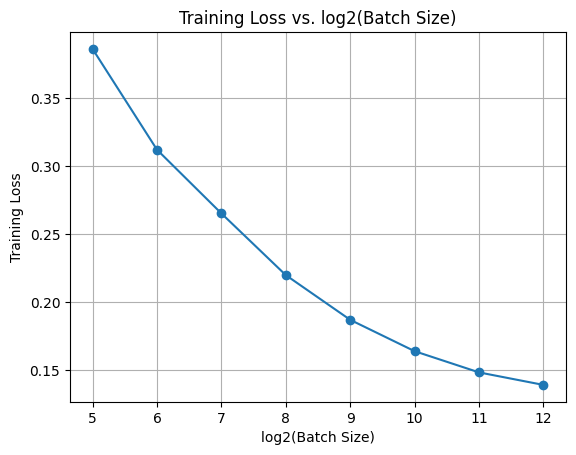

In [ ]:
import numpy as np
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), loss='categorical_crossentropy', metrics=['accuracy'])

# Define the range of batch sizes (32 to 4096 by the power of 2)
min_batch_size = 32
max_batch_size = 4096

# Initialize lists to store batch sizes and corresponding losses
batch_sizes = []
losses = []

# Initialize the current batch size to the minimum batch size
current_batch_size = min_batch_size

# Train the model for each batch size
while current_batch_size <= max_batch_size:
    history = model.fit(x_train, y_train, batch_size=current_batch_size, epochs=5, verbose=1)
    batch_sizes.append(np.log2(current_batch_size))
    losses.append(history.history['loss'][-1])

    # Increment the batch size by the power of 2
    current_batch_size *= 2

# Plot the training loss as a function of log2(batch size)
plt.plot(batch_sizes, losses, marker='o')
plt.title('Training Loss vs. log2(Batch Size)')
plt.xlabel('log2(Batch Size)')
plt.ylabel('Training Loss')
plt.grid(True)
plt.show()

In [ ]:
loss, validation_accuracy = model.evaluate(x_val, y_val)
print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")

313/313 [==============================] - 3s 10ms/step - loss: 0.4270 - accuracy: 0.8658
Validation Accuracy: 86.58%


**Answer:**

As the batch size increases the training loss decreases. The decrease in training time indicated an improvement in the model as batch size in increased.

Compared to the cyclical learning rate: I concluded above that the cyclical learning rate was affective in reducing loss and increasing accuray but batch size also reduced training time. The batch size reached a validation accuracy of 86.58% as compared to an accuracy of 87.6% on the cyclical learnign rate. These are similar values but the cyclical learning rate achieved a slightly better validation accuracy.




